In [33]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

class Forecaster():
    '''
    Object class to retrieve prices, forecast, and determine buy/sell actions
    '''
    def __init__(self, *args, **kwargs):
        '''
        Initialize with any specified tickers
        Parameters:
            tickers (str) : tickers to store
            price_type (str) : type of price during the interval 'Open', 'Close', 'High', 'Low'
            period (str) : length of time series - '5y', '1y', 'ytd', '10y'
            interval (str) : Interval of prices - '1wk', '1d'
            order (tuple) : (p, d, q)
            seasonal_order (tuple) : (P, D, Q, m)
        '''
        self.tickers = {}
        for arg in args:
            if arg.isupper() and len(arg)<=4: 
                self.tickers.setdefault(arg)
            else:
                print(f'Invalid ticker: {arg}')
        
        self.price_type = kwargs.get("price_type", 'High')
        self.period = kwargs.get("period", '5y')
        self.interval = kwargs.get("interval", '1wk')
        self.order = kwargs.get("order", (1, 1, 1))
        self.seasonal_order = kwargs.get("seasonal_order", (1, 1, 1, 52))

    def forecast(self, *args, **kwargs):
        '''
        Forecasts with SARIMA
        Parameters:
            tickers (str) : tickers to forecast, if none are specified, uses all the tickers stored in object
            price_type (str) : type of price during the interval 'Open', 'Close', 'High', 'Low'
            period (str) : length of time series - '5y', '1y', 'ytd', '10y'
            interval (str) : Interval of prices - '1wk', '1d'
            order (tuple) : (p, d, q)
            seasonal_order (tuple) : (P, D, Q, m)
        '''
        price_type = kwargs.get("price_type", self.price_type)
        period = kwargs.get("period", self.period)
        interval = kwargs.get("interval", self.interval)
        order = kwargs.get("order", self.order)
        seasonal_order = kwargs.get("seasonal_order", self.seasonal_order)

        if not args:
            args = self.tickers.keys()

        for ticker in args:
            print(f'Forecasting for {ticker}')
            stock = yf.Ticker(ticker)
            # print(stock.info)

            # get historical market data
            df = stock.history(period=period, interval=interval)
            if interval == '1wk':
                ts = df[[price_type]].to_period('W')
            elif interval == '1d':
                ts = df[[price_type]].to_period('D')

            model = ARIMA(ts, order=order,seasonal_order=seasonal_order)
            model_fit = model.fit()
            forecast = model_fit.predict(start=len(df), end = len(df)+seasonal_order[-1], dynamic=False)     
            self.tickers[ticker] = {'ts': ts, 'forecast': forecast}

    def forecast_validation(self, ticker = None, validation_periods = 52, forecast_only = True, **kwargs):
        '''
        Forecasts with SARIMA
        Parameters:
            tickers (str) : tickers to forecast, if none are specified, uses all the tickers stored in object
            price_type (str) : type of price during the interval 'Open', 'Close', 'High', 'Low'
            period (str) : length of time series - '5y', '1y', 'ytd', '10y'
            interval (str) : Interval of prices - '1wk', '1d'
            order (tuple) : (p, d, q)
            seasonal_order (tuple) : (P, D, Q, m)
        '''
        price_type = kwargs.get("price_type", self.price_type)
        period = kwargs.get("period", self.period)
        interval = kwargs.get("interval", self.interval)
        order = kwargs.get("order", self.order)
        seasonal_order = kwargs.get("seasonal_order", self.seasonal_order)

        if not ticker:
            ticker = list(self.tickers.keys())[0]
        print(f'Validating forecast for {ticker}')
        stock = yf.Ticker(ticker)
        # print(stock.info)

        # get historical market data
        df = stock.history(period=period, interval=interval)
        if interval == '1wk':
            ts = df[[price_type]].to_period('W')
        elif interval == '1d':
            ts = df[[price_type]].to_period('D')
        
        train, test = ts[:-validation_periods], ts[-validation_periods:]

        model = ARIMA(ts, order=order,seasonal_order=seasonal_order)
        model_fit = model.fit()
        forecast = model_fit.predict(start=len(train), end = len(train)+len(test), dynamic=False)  
        plt.figure(figsize=(14,6))
        plt.title(f'Validation for {ticker}')
        plt.plot(test.to_timestamp(), label='Actual')
        plt.plot(forecast.to_timestamp().shift(-1), color='red', label='Forecast')
        if not forecast_only:
            plt.plot(ts.to_timestamp())
        else:
            plt.xticks(forecast.index, rotation=45, fontsize=8)
            plt.legend()
            plt.grid()

    
    def plot_forecast(self, ticker: str=None, forecast_only: bool=False):
        '''
        Plots the forecasts and/or timeseries of prices
        Parameters:
            ticker (str) : ticker to plot from stored forecast
            forecast_only (bool) : whether to plot only the forecast or include past_prices
        '''
        try:
            # Use the init ticker
            if not ticker:
                ticker = list(self.tickers.keys())[0]
            ticker_data = self.tickers[ticker]
            ts, forecast = ticker_data['ts'], ticker_data['forecast']

            # Use .to_timestamp() to convert period back into timestamp for plotting
            plt.figure(figsize=(14,6))
            plt.title(f'Forecast for {ticker}')
            plt.plot(forecast.to_timestamp())
            if not forecast_only:
                plt.plot(ts.to_timestamp())
            else:
                plt.xticks(forecast.index, rotation=45, fontsize=8)
                plt.grid()

        except AttributeError as e:
            print(f'No forecasting done yet for {ticker}')
            

    def find_max_profit(self, *args):
        '''
        Finds the maximum profit possible without trading
        Parameters:
            ticker (str) : ticker to plot from stored forecast
        '''
        if not args:
            args = self.tickers.keys()

        for ticker in args:
            try:
                ticker_data = self.tickers.get(ticker, None)     
                forecast = ticker_data.get('forecast', None)  
                max_profit = 0
                high, low = None, None
                last_profit = None
                data = {}
                for period, price in zip(forecast.index, forecast):
                    data[period] = dict(current=price) # Saves every period as index
                    if not low or not high:
                        low = high = price # Initial assignment
                        low_idx, high_idx = period, period

                    # Find new lows, including the index
                    if price < low:
                        low, low_idx = price, period
                        high, high_idx = price, period # reset the high
                        data[period]['new_low'] = price

                    # Find new highs, including the index
                    if price > high:
                        high = price
                        high, high_idx = price, period
                        data[period]['new_high'] = price

                    # Calculate and check profit
                    profit = round((high - low)/low * 100, 2)
                    if profit > 0:
                        if profit != last_profit:
                            data[period]['profit %'] = profit
                    last_profit = profit

                    # Record the new max_profit
                    if profit > max_profit:
                        max_profit, buy, sell = profit, low_idx, high_idx
                        data[period]['new_max_profit'] = profit

                # Create final buy and sell action on the current period
                data[buy]['action'], data[sell]['action'] = 'buy', 'sell'
                df = pd.DataFrame(data).T
                df = df.fillna('')
                df = df[['current', 'profit %', 'new_low', 'new_high', 'new_max_profit', 'action']]

                # Filter for buy and sell action only
                actions = df[(df['action']=='buy') | (df['action']=='sell')][['current', 'profit %', 'action']]

                # Save the two dfs
                ticker_data['actions'] = actions
                ticker_data['profits'] = df

            except AttributeError:
                raise AttributeError(f'No forecasting done yet for {ticker}')
            except Exception as e:
                raise Exception(e)


Forecasting for TSLA


C:\Users\stell\AppData\Local\Temp\ipykernel_9272\1480350743.py:63: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  ts = df[[price_type]].to_period('W')


Validating forecast for TSLA


C:\Users\stell\AppData\Local\Temp\ipykernel_9272\1480350743.py:98: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  ts = df[[price_type]].to_period('W')


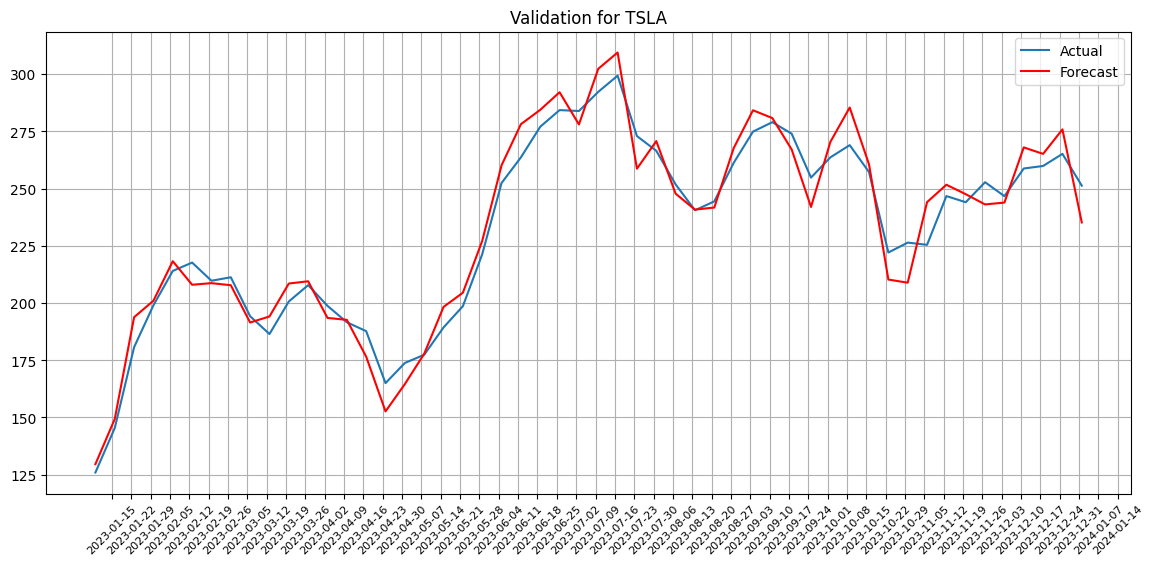

In [42]:
forecaster = Forecaster('TSLA', period='5y')

forecaster.forecast()
forecaster.forecast_validation()

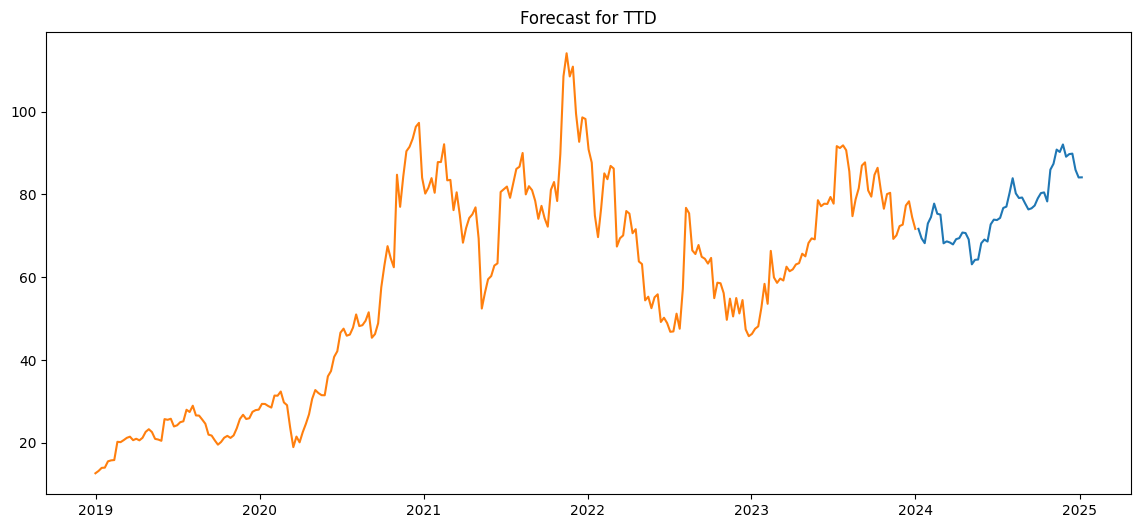

In [41]:
forecaster.plot_forecast(forecast_only=False)

In [44]:
forecaster.find_max_profit()

In [45]:
forecaster.tickers['TSLA']['profits']

,current,profit %,new_low,new_high,new_max_profit,action
2024-01-08/2024-01-14,235.179501,,,,,
2024-01-15/2024-01-21,234.882457,,234.882457,,,
2024-01-22/2024-01-28,237.061899,0.93,,237.061899,0.93,
2024-01-29/2024-02-04,238.905287,1.71,,238.905287,1.71,
2024-02-05/2024-02-11,237.864080,,,,,
2024-02-12/2024-02-18,236.126911,,,,,
2024-02-19/2024-02-25,224.977017,,224.977017,,,
2024-02-26/2024-03-03,223.440680,,223.44068,,,
2024-03-04/2024-03-10,216.259364,,216.259364,,,
2024-03-11/2024-03-17,216.931002,0.31,,216.931002,,
